# [E-5] Spectrogram classification 모델 구현

이번에는 2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델을 아래 제시된 단계와 같이 수행해 보시기 바랍니다. 이번에도 마찬가지로 기본 버전과 Skip-connection 버전으로 나누어 각각 진행해 보시기 바랍니다.
모델 구조를 제외하고는 실습에서 제시된 것과 거의 동일하게 진행될 것입니다. 

## 1. 데이터 처리와 분류

> - 라벨 데이터 처리하기
> - sklearn의 train_test_split함수를 이용하여 train, test 분리

### 1-1. 데이터 준비

In [ ]:
mkdir -p ~/aiffel/speech_recognition/data
mkdir -p ~/aiffel/speech_recognition/models
wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz -P ~/aiffel/speech_recognition/data

In [2]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [3]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [4]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  38232
Wave data shape :  (8000,)
label :  ['stop']


### 1-2. 라벨 데이터 처리하기

In [5]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [6]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

### 1-3. 1차원의 Waveform 데이터를 2차원의 Spctogram 데이터로 변환

In [ ]:
pip install librosa

In [7]:
import librosa

def wav2spec(wav, fft_size= 258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

spec_data = []
for wav in speech_data["wav_vals"]:
    spec_data.append(wav2spec(wav))
spec_data = np.array(spec_data)


print("✅")

✅


In [7]:
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


'wav2spec'으로 1차원인 'Waveform shape'을 Spectrogram은 (130, 126) 2차원으로 변환하였다.

### 1-4. sklearn의 train_test_split함수를 이용하여 train, test 분리

In [8]:
from sklearn.model_selection import train_test_split

sr = 130     # 2차원으로 변환된 것을 반영한다.
sc = 126
train_spec, test_spec, train_label, test_label = train_test_split(spec_data, 
                                                                label_data,                                                        
                                                                test_size = 0.1,
                                                                shuffle=True)
print(train_spec)

train_spec = train_spec.reshape([-1, sr, sc, 1]) # add channel for CNN
test_spec = test_spec.reshape([-1, sr, sc, 1])

print("✅")

[[[5.5055697e-02 2.5031567e-02 1.1901887e-02 ... 9.9963181e-02
   7.7022962e-02 6.6310421e-02]
  [1.8474087e-02 5.4092709e-02 6.3603953e-02 ... 5.7683893e-02
   3.7260320e-02 2.9595055e-02]
  [4.1177981e-03 5.6822605e-02 1.5945017e-01 ... 1.5553795e-02
   7.1175243e-03 1.3780339e-02]
  ...
  [5.0922739e-03 2.2498181e-03 5.6883134e-04 ... 5.8058352e-04
   2.4829800e-03 4.6176380e-03]
  [5.0084139e-03 2.6703533e-03 7.3788695e-05 ... 1.8564997e-04
   2.6182111e-03 4.8833075e-03]
  [5.0931759e-03 2.5190294e-03 5.5727076e-05 ... 5.8630223e-05
   2.3759915e-03 4.7659525e-03]]

 [[2.3076054e-02 8.0467556e-03 1.7946314e-03 ... 3.2100133e-03
   2.3037021e-03 2.6927816e-02]
  [3.5635121e-02 2.2944536e-02 1.2718392e-02 ... 2.5380233e-02
   2.6853925e-02 2.1427503e-02]
  [4.1142527e-02 2.8423982e-02 3.6954261e-02 ... 4.9313366e-02
   3.8083676e-02 9.8348884e-03]
  ...
  [5.7602925e-03 2.6331723e-03 5.4568879e-04 ... 5.8057421e-04
   2.1596418e-03 3.9901561e-03]
  [5.7117748e-03 3.0169850e-03 6.900

In [9]:
print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)

print("✅")

train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)
✅


##  2. 학습을 위한 하이퍼파라미터 설정

batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수이다.

In [9]:
batch_size = 8
max_epochs = 6

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj23/aiffel/speech_recognition/models/wav'

*메모리 버퍼 비워서 공간을 확보한다.

In [11]:
del speech_data
del spec_data

## 3. 데이터셋 구성

> - tf.data.Dataset을 이용
> - from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
> - map과 batch를 이용한 데이터 전처리
> - 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
> - tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.


In [10]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

print("✅")

✅


### 3-1. tf.data.Dataset, map과 batch를 이용한 데이터 전처리

* 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.

+ tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.

In [12]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

print("✅")

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

> - 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
> - batchnorm, dropout, dense layer 등을 이용
> - 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
> - 모델 가중치를 저장하는 checkpoint callback 함수 추가
> -다양한 모델의 실험을 진행해 보시기 바랍니다

### 4-1. Wave model

**- 모델 구성**

**Check point)** input shape은 130, 126, 1

In [14]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))   # 2차원 spectogram의 shape과 음성은 1채널

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)  # 2차원으로 변경
x = layers.Conv2D(32,  (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)     # 2차원으로 변경

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)


x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

**- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용**

In [15]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


**- 모델 가중치를 저장하는 checkpoint callback 함수 추가**

In [16]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


**- 학습하기**

In [17]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Train for 5694 steps, validate for 632 steps
Epoch 1/6
5690/5694 [============================>.] - ETA: 0s - loss: 0.7231 - accuracy: 0.7675
Epoch 00001: val_loss improved from inf to 0.31980, saving model to /home/aiffel-dj23/aiffel/speech_recognition/models/wav
5694/5694 [==============================] - 88s 16ms/step - loss: 0.7229 - accuracy: 0.7676 - val_loss: 0.3198 - val_accuracy: 0.8989
Epoch 2/6
5692/5694 [============================>.] - ETA: 0s - loss: 0.2880 - accuracy: 0.9119
Epoch 00002: val_loss improved from 0.31980 to 0.17555, saving model to /home/aiffel-dj23/aiffel/speech_recognition/models/wav
5694/5694 [==============================] - 84s 15ms/step - loss: 0.2880 - accuracy: 0.9119 - val_loss: 0.1756 - val_accuracy: 0.9446
Epoch 3/6
5693/5694 [============================>.] - ETA: 0s - loss: 0.1869 - accuracy: 0.9426
Epoch 00003: val_loss improved from 0.17555 to 0.14667, saving model to /home/aiffel-dj23/aiffel/speech_recognition/models/wav
5694/5694 [======

### 4-2. Skip-Connection model

**- 모델 구성**

In [15]:
from tensorflow.keras.models import load_model

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 130, 126, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 130, 126, 32) 9248        conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_11[0][0]                  
____________________________________________________________________________________________

**- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용**

In [16]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


**- 모델 가중치를 저장하는 checkpoint callback 함수 추가**

In [17]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


**- 학습하기**

In [18]:
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Train for 5694 steps, validate for 632 steps
Epoch 1/6
5690/5694 [============================>.] - ETA: 0s - loss: 0.8214 - accuracy: 0.7354
Epoch 00001: val_loss improved from inf to 0.29174, saving model to /home/aiffel-dj23/aiffel/speech_recognition/models/wav_skip
5694/5694 [==============================] - 98s 17ms/step - loss: 0.8212 - accuracy: 0.7355 - val_loss: 0.2917 - val_accuracy: 0.9094
Epoch 2/6
5692/5694 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.9036
Epoch 00002: val_loss improved from 0.29174 to 0.19056, saving model to /home/aiffel-dj23/aiffel/speech_recognition/models/wav_skip
5694/5694 [==============================] - 95s 17ms/step - loss: 0.3125 - accuracy: 0.9036 - val_loss: 0.1906 - val_accuracy: 0.9442
Epoch 3/6
5691/5694 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9384
Epoch 00003: val_loss improved from 0.19056 to 0.15076, saving model to /home/aiffel-dj23/aiffel/speech_recognition/models/wav_skip
56

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

> - loss, accuracy를 그래프로 표현 

### 1. Wave model

**- 학습 결과 Plot**

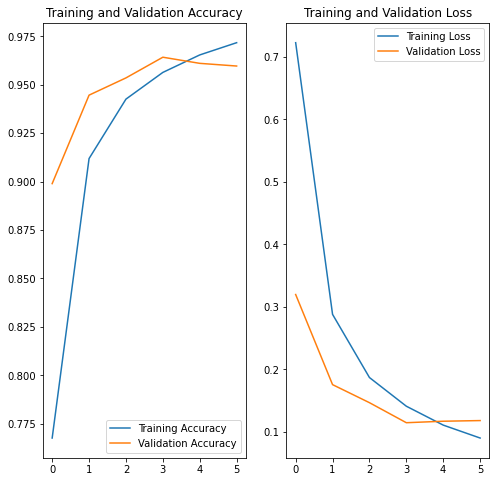

✅


In [19]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

### 2. Skip-Connection model

**- 학습 결과 Plot**

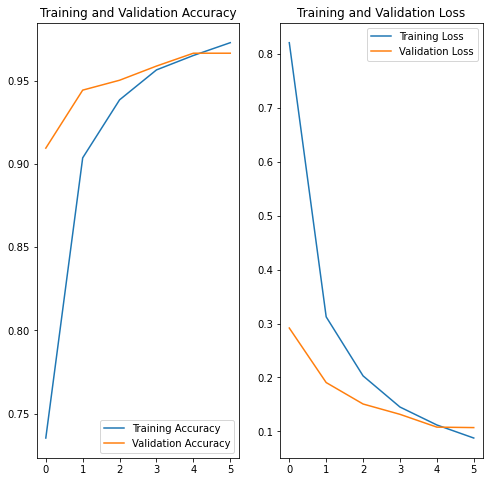

✅


In [19]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 6. Test dataset을 이용해서 모델의 성능을 평가

> - 저장한 weight 불러오기
> - 모델의 예측값과 정답값이 얼마나 일치하는지 확인

### 1. Wave model

**- 저장한 weight 불러오기**

In [20]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


**- 평가하기**

In [21]:
results = model_wav.evaluate(test_dataset)

print("✅")

633/633 [==============================] - 3s 5ms/step - loss: 0.1147 - accuracy: 0.9640
✅


In [28]:
# loss
print("loss value: {:.3f}".format(results[0]))

# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

print("✅")

loss value: 0.107
accuracy value: 96.6416%
✅


**결과)** 최종적으로 손실은 0.107, 정확도는 96.64% 이다.

**- 테스트셋의 라벨과 모델의 실제 prediction 결과 비교**

In [23]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130, 126,), rate=8000)

label :  down


In [24]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: down(Correct!)
✅


**결과)** 테스트셋의 라벨과 모델의 실제 예상 결과과 일치한다.

### 2. Skip-Connection model

**- 저장한 weight 불러오기**

In [20]:
model_wav_skip.load_weights(checkpoint_dir)
print("✅")

✅


**- 평가하기**

In [21]:
results = model_wav_skip.evaluate(test_dataset)
print("✅")

633/633 [==============================] - 4s 6ms/step - loss: 0.1068 - accuracy: 0.9664
✅


In [23]:
# loss
print("loss value: {:.3f}".format(results[0]))

# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.107
accuracy value: 96.6416%
✅


**결과)** 최종적으로 손실은 0.107, 정확도는 96.64% 이다.

**- 테스트셋의 라벨과 모델의 실제 prediction 결과 비교**

In [25]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130, 126,), rate=8000)

label :  up


In [26]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: up(Correct!)
✅


**결과)** 테스트셋의 라벨과 모델의 실제 예상 결과과 일치한다.

## 결과

> 결과적으로 두 모델 모두 최종적으로 손실은 0.107, 정확도는 96.64% 가 나왔다.
> 제대로 실행한 것이 맞는지 결과를 보고 의문이 들었지만, 학습결과를 시각화 한 그래프를 보니
> 미미한 차이가 발견되었다.

## 총평

> Wave Model을 돌리고 나니 커널이 죽어서, Skip-Connection Model을 따로 한번 더 돌리다 
> 보니, 실행 순서가 뒤죽박죽이다.
>
> 일주일 동안 음성 데이터의 분류 프로젝트를 진행하며, 어느 때보다 많이 힘들었다.
> 이번 노드의 내용을 이해하기도 어려웠고, 프로젝트 진행을 해나가기 위해 생소한 코드를 작성
> 해야 하는 것이 큰 난관이었다. 매주 수업을 통해 이제야 파이썬의 언어인 코드를 배우고 있는
> 데, 코드를 작성해야 하니 쉬운 일이 아니다. 
>
> 그래도 끝까지 포기하지 않고 이른 아침에 시간을 내어 1-2시간씩 꾸준히 시도하니, 이해가 
> 가지 않던 부분들도 이제는 맥락적인 이해가 가능하다.(완벽한 이해는 6개월 후에는 가능하겠지 > 하며 스스로를 격려해 본다 ㅠㅜ)
>
> 그리고 커널이 자꾸 꺼지는 문제도 난관 중에 하나였는데, 슬랙에서 이미 같은 문제에 대해 
> 고민하신 분들의 글을 읽으면서 많은 도움을 받았다.
>
> 지난주에는 발견된 에러들에 대해 곧바로 팀원들과 토론을 통해 해결을 해보자 생각했는데, 
> 가장 문제가되는 에러들에도 도달하기 까지 너무 많은 시간이 걸렸다. (그 에러에 도달하기 전 
> 슬랙에서 해결책들을 봐도 와닿지 않기 때문에...)
> 
> 다음에는 에러에 도달하는 시간이 짧아지기를, 그리고 다양한 시도를 해볼 여유가 생기기를 
> 바란다.